In [1]:
%matplotlib inline

import numpy as np
import xarray
import matplotlib.pyplot as plt

# spectral feedback scripts
import theory

### Plot feedback map, using ERA5 data + analytical expressions 

#### First, define some utility functions:

In [2]:
# Wrapper fn for computing feedbacks
#   useful so I can switch out GCM vs ERA5 data etc
#   Right now the theory scripts don't work well with xarray inputs so make all inputs numpy.
#   this fn deals with converting to numpy and back.
#
# NOTES:
#    - assumes pCO2 is a scalar.
#    - assumes params is an object/class Dummy() or similar
#    - the feedback scripts currently don't work with xarray datasets! => use numpy instead
#    - get issues from Planck.Planck_n if dtype=float32 (why?), so use .astype(np.float64)

# some helpers:
params = theory.Feedback_scalings.get_default_params()
pCO2 = 400e-6

# main function:
def compute_feedbacks(Ts,Tstrat,RH,gammaLR=None,dgammaLRdTs=None):
    # convert xarray to numpy + float64
    Ts_np = Ts.to_numpy().astype(np.float64)
    Tstrat_np = Tstrat.to_numpy().astype(np.float64)
    RH_np = RH.to_numpy().astype(np.float64)
    if gammaLR is not None: gammaLR_np = gammaLR.to_numpy().astype(np.float64)
    else: gammaLR_np = None
        
    if dgammaLRdTs is not None: dgammaLRdTs_np = dgammaLRdTs.to_numpy().astype(np.float64)
    else: dgammaLRdTs_np = None

    # calculate feedback
    lambda_surf = theory.Feedback_scalings.get_lambda_surf(Ts_np,Tstrat_np,RH_np,params,pCO2,gammaLR=gammaLR_np)
    lambda_co2,_,_ = theory.Feedback_scalings.get_lambda_co2(Ts_np,Tstrat_np,RH_np,params,pCO2,normalize_jump=False,gammaLR=gammaLR_np,dgammaLRdTs=dgammaLRdTs_np)
    lambda_h2o,_ = theory.Feedback_scalings.get_lambda_h2o(Ts_np,Tstrat_np,RH_np,params,pCO2,gammaLR=gammaLR_np,dgammaLRdTs=dgammaLRdTs_np)
    lambda_cntm,_ = theory.Feedback_scalings.get_lambda_cntm(Ts_np,Tstrat_np,RH_np,params,pCO2,gammaLR=gammaLR_np,dgammaLRdTs=dgammaLRdTs_np)
    
    # .. fix sign so feedbacks are negative
    lambda_surf = -1* lambda_surf
    lambda_co2 = -1* lambda_co2
    lambda_h2o = -1* lambda_h2o
    lambda_cntm = -1* lambda_cntm

    # convert back to xarray
    lambda_surf = xarray.DataArray( lambda_surf,
                               coords={'latitude': Ts.coords['latitude'],'longitude': Ts.coords['longitude']},
                               dims=["latitude", "longitude"])
    lambda_co2 = xarray.DataArray( lambda_co2,
                               coords={'latitude': Ts.coords['latitude'],'longitude': Ts.coords['longitude']},
                               dims=["latitude", "longitude"])
    lambda_h2o = xarray.DataArray( lambda_h2o,
                               coords={'latitude': Ts.coords['latitude'],'longitude': Ts.coords['longitude']},
                               dims=["latitude", "longitude"])
    lambda_cntm = xarray.DataArray( lambda_cntm,
                               coords={'latitude': Ts.coords['latitude'],'longitude': Ts.coords['longitude']},
                               dims=["latitude", "longitude"])
    
    return lambda_surf,lambda_co2,lambda_h2o,lambda_cntm

In [3]:
# Compute gammaLR
#   here: vertical mean of [ dlnT/dlnp] = vertical mean of [ p/T*dT/dp]
#   note: make sure the vertical units are correct! Here, assuming mbar.
def compute_gammaLR(ds_ta,mask_stratosphere=True,mask_nearSurface=True):
    # 1. compute gradient dlnT/dlnp from data
    gg = (ds_ta.level/ds_ta) * ds_ta.differentiate('level')

    # 2. mask stratosphere and/or near-surface areas (=inversion areas)
    if mask_stratosphere:
        mask_troposphere = ds_ta.level >= 100. + 200.*np.abs(ds_ta.latitude)/90.   # Soden tropopause defn.
        gg = gg.where(mask_troposphere)
        
    if mask_nearSurface:
        mask_surface = gg.level <= 1000. - 150.*np.abs(gg.latitude)/90.   # ...
        gg = gg.where(mask_surface)
        
    # 3. take vertical avg
    weights_p = ds_ta.level
    gg_weighted = gg.weighted(weights_p)
    ds_gammaLR = gg_weighted.mean('level',skipna=True)
    ds_gammaLR = ds_gammaLR.rename('gammaLR')
    return ds_gammaLR

In [4]:
# Compute (area weighted) lat-lon global mean
def get_latlon_mean(ds):
    w = np.cos(np.deg2rad(ds.latitude))
    w = w/w.mean()
    w.name = "weights"
    return ds.weighted(w).mean(["latitude","longitude"]).to_numpy()

#### Second, open data using xarray:

Helpful scripts for advanced interpolation:
https://xarray.pydata.org/en/stable/user-guide/interpolation.html#advanced-interpolation

In [5]:
## Open netcdfs
##  NOTE: data was already time-averaged
datadir = './era5_data/'

## 1) get Ts
ds = xarray.open_dataset(datadir+'tsurf_psurf.1x1deg.yr1980-1999_avg.nc')
Ts = ds.t2m
print("Ts:\t",Ts)

## 2) get RH
ds = xarray.open_dataarray(datadir+'ColumnRH_1980-1_1999-12_avg.nc')
RH = ds
print("RH:\t",RH)

## 3) get Ta
ds = xarray.open_dataset(datadir+'temp_rh_q.1x1deg.yr1980-1999_avg.nc')

Ta = ds.t
print("Ta:\t",Ta)

Ts:	 <xarray.DataArray 't2m' (latitude: 181, longitude: 360)>
array([[258.64944, 258.64944, 258.64944, ..., 258.64944, 258.64944, 258.64944],
       [258.97946, 258.9808 , 258.98218, ..., 258.9861 , 258.98395, 258.98166],
       [259.24203, 259.24042, 259.2382 , ..., 259.2386 , 259.2354 , 259.23883],
       ...,
       [228.5366 , 228.49893, 228.46092, ..., 228.6021 , 228.57286, 228.55495],
       [228.16376, 228.15399, 228.1441 , ..., 228.20341, 228.19002, 228.17683],
       [227.81505, 227.81505, 227.81505, ..., 227.81505, 227.81505, 227.81505]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
RH:	 <xarray.DataArray (latitude: 181, longitude: 360)>
array([[0.653612, 0.653612, 0.653612, ..., 0.653612, 0.653612, 0.653612],
       [0.651731, 0.6518  , 0.651887, ..., 0.651479, 0.651565, 0.651651],
       [0.649204, 0.649479, 0.649753, ..., 0.648578,

#### Third, compute related input quantities from data:

Tstrat:
use Soden et al criterion, based on a simple latitudinal pressure mask;
make sure units of 'level' are mbar;


In [6]:
#
Tstrat = ds.t.interp(latitude=ds.latitude,longitude=ds.longitude,level=100. + 200.*np.abs(ds.latitude)/90.,method="linear")
print("Tstrat:\t",Tstrat)

#
gammaLR = compute_gammaLR(Ta)
print("gammaLR:\t",gammaLR)

Tstrat:	 <xarray.DataArray 't' (latitude: 181, longitude: 360)>
array([[219.03133, 219.03133, 219.03133, ..., 219.03133, 219.03133,
        219.03133],
       [219.06358, 219.0635 , 219.06367, ..., 219.06355, 219.06346,
        219.06339],
       [219.10423, 219.1041 , 219.104  , ..., 219.10495, 219.10477,
        219.10446],
       ...,
       [212.78111, 212.77399, 212.76678, ..., 212.80203, 212.79518,
        212.78824],
       [212.83684, 212.83333, 212.82976, ..., 212.84753, 212.84393,
        212.84033],
       [212.94518, 212.94518, 212.94518, ..., 212.94518, 212.94518,
        212.94518]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
    level      (latitude) float32 300.0 297.8 295.6 293.3 ... 295.6 297.8 300.0
gammaLR:	 <xarray.DataArray 'gammaLR' (latitude: 181, longitude: 360)>
array([[0.1324409 , 0.1324409 , 0.1324409 , ..., 0.1324409 , 

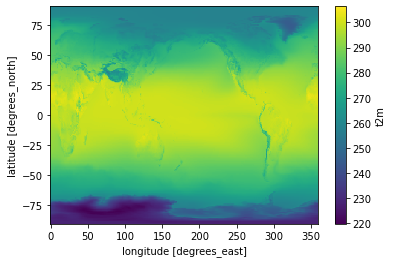

In [7]:
# ... SANITY CHECKS:
Ts.plot()

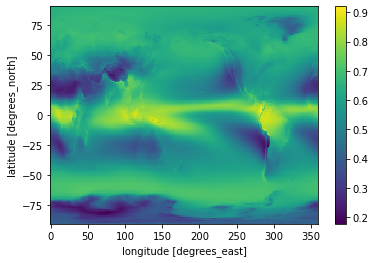

In [8]:
RH.plot()

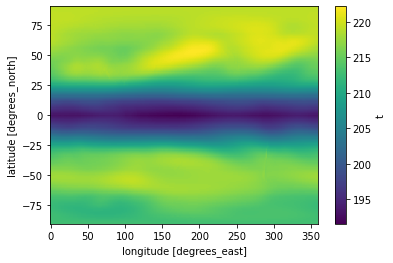

In [9]:
Tstrat.plot()

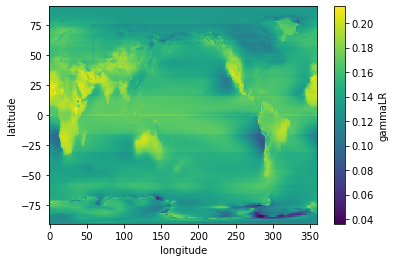

In [10]:
gammaLR.plot()

#### Four, MAIN CALCULATION ...

Here: ERA5 data does not give d(gammaLR)/dTs. Here, assume that lapse rate changes are moist adiabatic instead.

In [11]:
lambda_surf,lambda_co2,lambda_h2o,lambda_cntm = compute_feedbacks(Ts,Tstrat,RH,gammaLR,dgammaLRdTs=None)

In [12]:
lambda_net = lambda_surf + lambda_co2 + lambda_h2o + lambda_cntm

#### Five, compute global means

In [13]:
lambda_net_mean = get_latlon_mean(lambda_net)
lambda_surf_mean = get_latlon_mean(lambda_surf)
lambda_co2_mean = get_latlon_mean(lambda_co2)
lambda_h2o_mean = get_latlon_mean(lambda_h2o)
lambda_cntm_mean = get_latlon_mean(lambda_cntm)

#
print( "<lambda_net> =\t", lambda_net_mean, " W/m2/K" )
print( "<lambda_surf> =\t", lambda_surf_mean, " W/m2/K" )
print( "<lambda_co2> =\t", lambda_co2_mean, " W/m2/K" )
print( "<lambda_h2o> =\t", lambda_h2o_mean, " W/m2/K" )
print( "<lambda_cntm> =\t", lambda_cntm_mean, " W/m2/K" )

<lambda_net> =	 -2.2805156840201395  W/m2/K
<lambda_surf> =	 -1.3117076175583986  W/m2/K
<lambda_co2> =	 -0.5123437725842689  W/m2/K
<lambda_h2o> =	 -0.510613838564473  W/m2/K
<lambda_cntm> =	 0.05414954468700231  W/m2/K


### Six, make plot

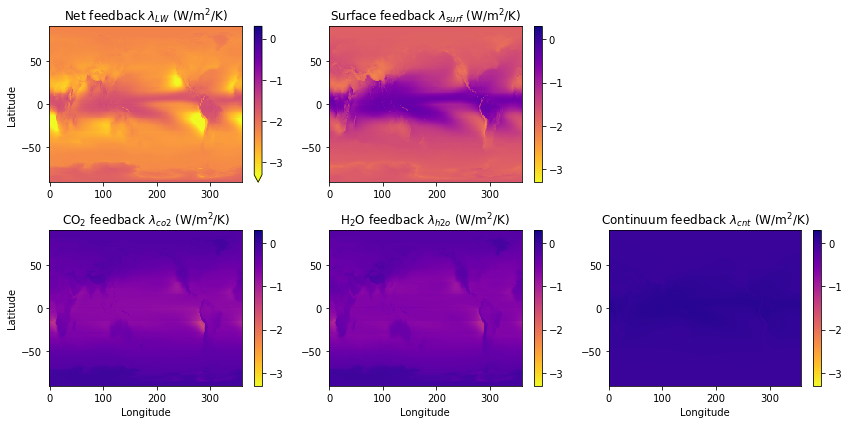

In [14]:
vmin,vmax=-3.3,0.3
cmap = "plasma_r"

plt.figure(figsize=[12,6])
#
plt.subplot(2,3,1)
lambda_net.plot(rasterized=True,vmin=vmin,vmax=vmax,cmap=cmap)
plt.title("Net feedback $\\lambda_{LW}$ (W/m$^2$/K)")
plt.xlabel("")
plt.ylabel("Latitude")
#
plt.subplot(2,3,2)
lambda_surf.plot(rasterized=True,vmin=vmin,vmax=vmax,cmap=cmap)
plt.title("Surface feedback $\\lambda_{surf}$ (W/m$^2$/K)")
plt.xlabel("")
plt.ylabel("")
#
plt.subplot(2,3,4)
lambda_co2.plot(rasterized=True,vmin=vmin,vmax=vmax,cmap=cmap)
plt.title("CO$_2$ feedback $\\lambda_{co2}$ (W/m$^2$/K)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
#
plt.subplot(2,3,5)
lambda_h2o.plot(rasterized=True,vmin=vmin,vmax=vmax,cmap=cmap)
plt.title("H$_2$O feedback $\\lambda_{h2o}$ (W/m$^2$/K)")
plt.xlabel("Longitude")
plt.ylabel("")
#
plt.subplot(2,3,6)
lambda_cntm.plot(rasterized=True,vmin=vmin,vmax=vmax,cmap=cmap)
plt.title("Continuum feedback $\\lambda_{cnt}$ (W/m$^2$/K)")
plt.xlabel("Longitude")
plt.ylabel("")
#
plt.tight_layout()
plt.savefig("plot_theory_feedback_map.pdf",format="pdf")